In [1]:
import sys
sys.path.append('../../lib/')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from jax.example_libraries.optimizers import adam, unpack_optimizer_state, pack_optimizer_state
import pickle

jax.config.update('jax_platform_name', 'cpu')
from hetero_simulation.econ_models.very_simple import neural_network, econ_config, ml_config, loss, params0
from hetero_simulation.archive.agent import log_utility
from hetero_simulation.ml.utils import *
utility = lambda c: log_utility()(c)

In [2]:
opt_init, opt_update, get_params = adam(step_size=0.001)
saved_params = pickle.load(open(f'../models/very_simple_model_latest.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_params)
params = get_params(opt_state)

In [3]:
m = jnp.linspace(1e-10, 2, 10001)
t = jnp.concatenate((jnp.zeros(333), jnp.ones(334), 2 * jnp.ones(333)))

In [4]:
t0 = 0.
v0, c0, m1, bc, l0 = jax.vmap(lambda m0: neural_network(params, m0, t0))(m)
v1f = lambda params, m1, t1: neural_network(params, m1, t1)[0]
v1 = jax.vmap(lambda m1: v1f(params, m1, t0 + 1))(m)

v0f = lambda params, m0, t0: neural_network(params, m0, t0)[0]
v0_grad = jax.vmap(lambda m0: jax.grad(v0f, (1,))(params, m0, t0))(m)
v0 = jax.vmap(lambda m0: v0f(params, m0, t0))(m)
v0m = v0_grad[0]

v1f = lambda params, m1, t1: neural_network(params, m1, t1)[0]
v1 = jax.vmap(lambda m1: v1f(params, m1, t0 + 1))(m)
v1_grad = jax.vmap(lambda m1: jax.grad(v1f, (1,))(params, m1, t0 + 1))(m)
v1m = v1_grad[0]

u = jax.vmap(utility)(c0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1),
                                   m1.reshape(-1, 1), 
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), m.reshape(-1, 1), u.reshape(-1, 1),
                                   v0m.reshape(-1, 1), 
                                   v1m.reshape(-1, 1)),
                                   axis=1))
df.columns = ['rc', 'rm', 'rbc', 'rv0', 'rv1', 'rl0', 'm0', 'ru', 'rv0m', 'rv1m']
df.set_index('m0', inplace=True)

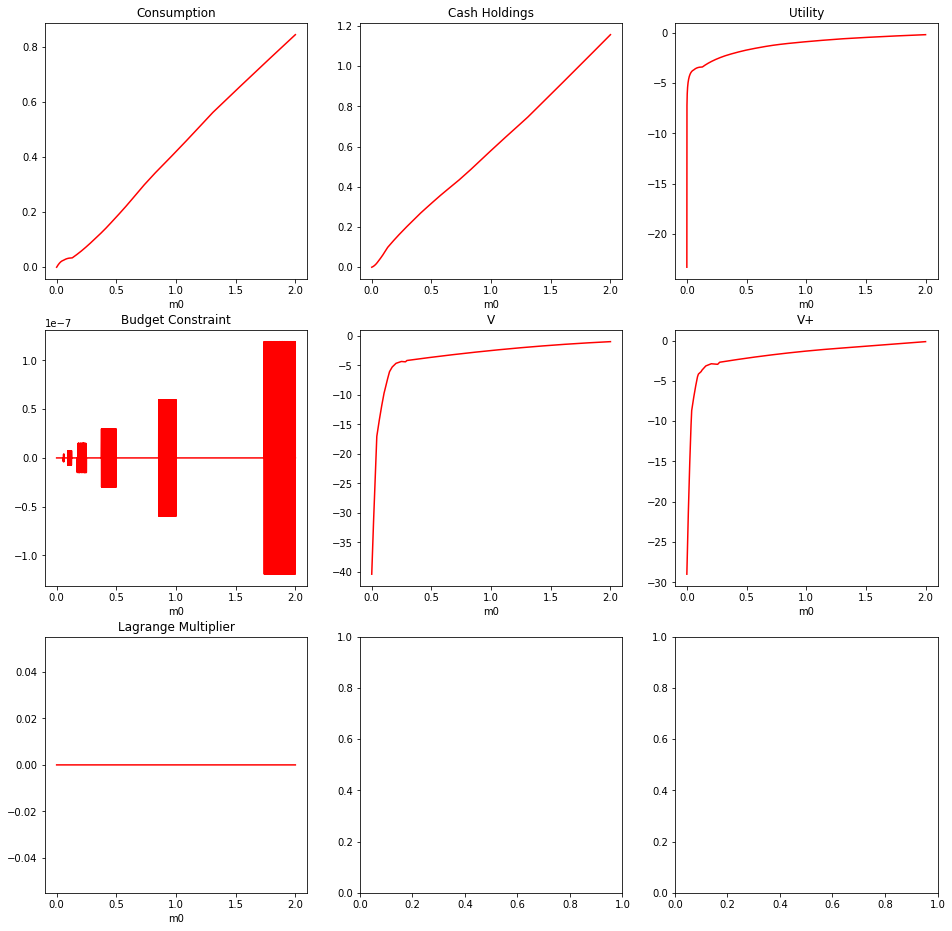

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['rc'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['rm'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='red')
_ = df['ru'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='red')
_ = df['rbc'].plot(kind='line', ax=axes.flatten()[3], title='Budget Constraint', c='red')
_ = df['rv0'].plot(kind='line', ax=axes.flatten()[4], title='V', c='red')
_ = df['rv1'].plot(kind='line', ax=axes.flatten()[5], title='V+', c='red')
_ = df['rl0'].plot(kind='line', ax=axes.flatten()[6], title='Lagrange Multiplier', c='red')

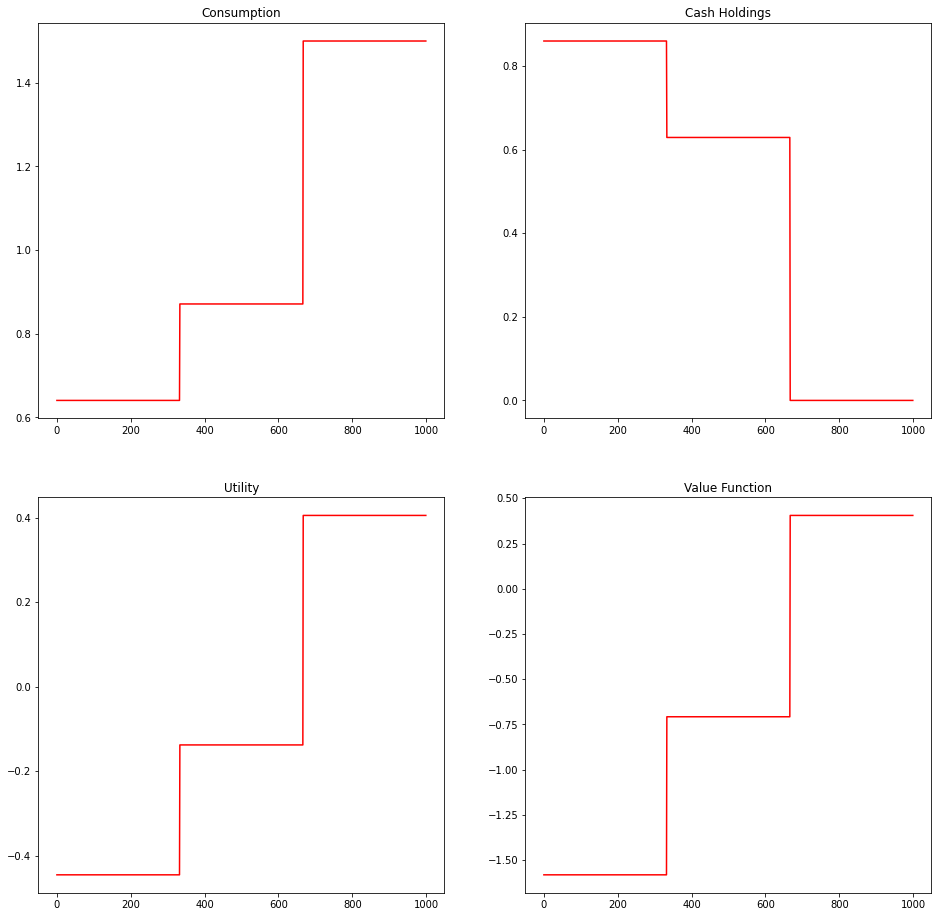

In [6]:
m0 = 1.5 * jnp.ones(1)
v0, c0, m1, bc, l0 = jax.vmap(lambda t0: neural_network(params, m0, t0))(t)
u = jax.vmap(utility)(c0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), 
                                   m1.reshape(-1, 1), 
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'm', 'bc', 'v', 'u']

fig, axes = plt.subplots(2, 2, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['m'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='red')
_ = df['u'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='red')
_ = df['v'].plot(kind='line', ax=axes.flatten()[3], title='Value Function', c='red')

In [7]:
from hetero_simulation.econ_models.very_simple import neural_network

m0 = 1. * jnp.ones(1)
v0, c0, m1, bc0, l0 = neural_network(params, m0, 0.)
v1, c1, m2, bc1, l1 = neural_network(params, m1, 1.)
v2, c2, m3, bc2, l2 = neural_network(params, m2, 2.)

t = jnp.arange(1, 4)
m = jnp.concatenate((m1, m2, m3))
c = jnp.concatenate((c0, c1, c2))
v = jnp.concatenate((v0.reshape(1), v1.reshape(1), v2.reshape(1)))
u = jax.vmap(utility)(c)

model_df = pd.DataFrame(jnp.concatenate((c.reshape(-1, 1), t.reshape(-1, 1), m.reshape(-1, 1), 
                                   v.reshape(-1, 1), u.reshape(-1, 1)), axis=1))
model_df.columns = ['c', 't', 'm', 'v', 'u']
model_df.set_index('t', inplace=True)

ValueError: Zero-dimensional arrays cannot be concatenated.

In [ ]:
def neural_network(params, m0, t0):
    c0 = jnp.nan_to_num(m0 / jnp.sum(econ_config['beta'] ** jnp.arange(econ_config['T'] - (t0 - 1))), 0, 0, 0)
    m1 = m0 - c0
    bc = 0
    l0 = jnp.nan_to_num(1 / c0, 0, 0, 0)

    r = jnp.arange(econ_config['T'] - t0 + 1)
    s = jnp.sum(econ_config['beta'] ** r)
    f = jnp.sum(r * econ_config['beta'] ** r)
    v0 = jnp.nan_to_num(s * (jnp.log(m0) - jnp.log(s)) + f * jnp.log(econ_config['beta']), 0, 0, 0)

    return (v0, c0, m1, bc, l0)

v0, c0, m1, bc0, l0 = neural_network(params, m0, 0.)
v1, c1, m2, bc1, l1 = neural_network(params, m1, 1.)
v2, c2, m3, bc2, l2 = neural_network(params, m2, 2.)

t = jnp.arange(1, 4)
m = jnp.concatenate((m1, m2, m3))
c = jnp.concatenate((c0, c1, c2))
u = jnp.log(c)
v = jnp.concatenate((v0, v1, v2))

true_df = pd.DataFrame(jnp.concatenate((c.reshape(-1, 1), t.reshape(-1, 1), m.reshape(-1, 1), 
                                        v.reshape(-1, 1), u.reshape(-1, 1)), axis=1))
true_df.columns = ['c', 't', 'm', 'v', 'u']
true_df.set_index('t', inplace=True)

In [ ]:
model_df.join(true_df, lsuffix='_model', rsuffix='_true').join((model_df - true_df)**2, rsuffix='_diff')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
_ = true_df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = true_df['m'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='red')
_ = true_df['u'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='red')
_ = true_df['v'].plot(kind='line', ax=axes.flatten()[3], title='Value Function', c='red')
_ = model_df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='blue')
_ = model_df['m'].plot(kind='line', ax=axes.flatten()[1], title='Cash Holdings', c='blue')
_ = model_df['u'].plot(kind='line', ax=axes.flatten()[2], title='Utility', c='blue')
_ = model_df['v'].plot(kind='line', ax=axes.flatten()[3], title='Value Function', c='blue')
_ = fig.legend(['Truth', 'Estimate'])
for ax in axes.flatten():
    ax.axvline(x=2., color='grey', linestyle='--', alpha=0.5)

In [ ]:
def loss(params, m0, t0):
    v0, c0, m1, bc0, l0 = neural_network(params, m0, t0)
    v1, c1, m2, bc1, l1 = neural_network(params, m1, t0 + 1)

    utility = lambda c: jnp.log(c)
    u = utility(c0)
    uc = jax.grad(utility)(c[0])

    vf = lambda m, t: jnp.squeeze(neural_network(params, m, t)[0])
    v0m = jax.grad(vf, 0)(m0, t0)
    v1m = jax.grad(vf, 1)(m1, t0 + 1)

    live_next = jnp.int32(t0 < econ_config['T'])
    loss_euler = ((c1 / (econ_config['beta'] * c0)) - 1) * live_next
    loss_bellman = ((u + econ_config['beta'] * v1) - v0)
    loss_focm1 = 0 # (((econ_config['beta'] * v1m) / l0) - 1) * live_next
    loss_focm0 = ((l0 / v0m) - 1)
    loss_value = 0 # u + econ_config['beta'] * v1
    loss_focc = 0 # (uc / l0) - 1

    return loss_bellman**2, loss_value**2, loss_focc**2, loss_focm1**2, loss_focm0**2, loss_euler**2

In [ ]:
m = jnp.linspace(1e-10, 2, 10001)
t = jnp.concatenate((jnp.zeros(1), jnp.ones(1), 2 * jnp.ones(1)))

with jax.disable_jit():
    loss_bellman0, loss_value0, loss_focc0, loss_focm10, loss_focm00, loss_euler0 = jax.vmap(lambda m: loss(params, m, t[0]))(m)

    loss_bellman1, loss_value1, loss_focc1, loss_focm11, loss_focm01, loss_euler1 = jax.vmap(lambda m: loss(params, m, t[1]))(m)

    loss_bellman2, loss_value2, loss_focc2, loss_focm12, loss_focm02, loss_euler2 = jax.vmap(lambda m: loss(params, m, t[2]))(m)

v0s, c0s, m1s, bc0s, l0s = jax.vmap(lambda m0: neural_network(params, m0, t[0]))(m)
v1s, c1s, m2s, bc1s, l1s = jax.vmap(lambda m0: neural_network(params, m0, t[1]))(m)
v2s, c2s, m3s, bc2s, l2s = jax.vmap(lambda m0: neural_network(params, m0, t[2]))(m)

df = pd.DataFrame(jnp.concatenate((v0s.reshape(-1, 1), c0s.reshape(-1, 1), m1s.reshape(-1, 1), bc0s.reshape(-1, 1), l0s.reshape(-1, 1),
                                   v1s.reshape(-1, 1), c1s.reshape(-1, 1), m2s.reshape(-1, 1), bc1s.reshape(-1, 1), l1s.reshape(-1, 1),
                                   v2s.reshape(-1, 1), c2s.reshape(-1, 1), m3s.reshape(-1, 1), bc2s.reshape(-1, 1), l2s.reshape(-1, 1),
                                   loss_bellman0.reshape(-1, 1), loss_value0.reshape(-1, 1), loss_focc0.reshape(-1, 1), loss_focm10.reshape(-1, 1), loss_focm00.reshape(-1, 1), loss_euler0.reshape(-1, 1),
                                   loss_bellman1.reshape(-1, 1), loss_value1.reshape(-1, 1), loss_focc1.reshape(-1, 1), loss_focm11.reshape(-1, 1), loss_focm01.reshape(-1, 1), loss_euler1.reshape(-1, 1),
                                   loss_bellman2.reshape(-1, 1), loss_value2.reshape(-1, 1), loss_focc2.reshape(-1, 1), loss_focm12.reshape(-1, 1), loss_focm02.reshape(-1, 1), loss_euler2.reshape(-1, 1)),
                    axis=1))

df.columns = [
    'v0s', 'c0s', 'm1s', 'bc0s', 'l0s', 'v1s', 'c1s', 'm2s', 'bc1s', 'l1s', 'v2s', 'c2s', 'm3s', 'bc2s', 'l2s',
    'loss_bellman0', 'loss_value0', 'loss_focc0', 'loss_focm10', 'loss_focm00', 'loss_euler0',
    'loss_bellman1', 'loss_value1', 'loss_focc1', 'loss_focm11', 'loss_focm01', 'loss_euler1',
    'loss_bellman2', 'loss_value2', 'loss_focc2', 'loss_focm12', 'loss_focm02', 'loss_euler2'
]

In [ ]:
df

In [ ]:
jnp.mean(loss_bellman0 + loss_value0 + loss_focc0 + loss_focm10 + loss_focm00 + loss_euler0)

In [ ]:
jnp.mean(loss_bellman1 + loss_value1 + loss_focc1 + loss_focm11 + loss_focm01 + loss_euler1)

In [ ]:
jnp.mean(loss_bellman2 + loss_value2 + loss_focc2 + loss_focm12 + loss_focm02 + loss_euler2)

In [ ]:
df[['loss_bellman0', 'loss_value0', 'loss_focc0', 'loss_focm10', 'loss_focm00', 'loss_euler0']].plot()

In [ ]:
df[['loss_bellman1', 'loss_value1', 'loss_focc1', 'loss_focm11', 'loss_focm01', 'loss_euler1']].plot()

In [ ]:
df[['loss_bellman2', 'loss_value2', 'loss_focc2', 'loss_focm12', 'loss_focm02', 'loss_euler2']].plot()

In [ ]:
df[['loss_focm00', 'loss_focm01', 'loss_focm02']]

In [ ]:
jnp.mean(loss_focm02)

In [ ]:
jnp.exp(-2.698289394378662)

In [ ]:
jnp.sum(econ_config['beta'] ** jnp.arange(econ_config['T'] - 0 + 1))

In [ ]:
t0 = 0
betas = econ_config['beta'] ** jnp.arange(econ_config['T'] - 0 + 1)
base = (1 - econ_config['beta']) / (1 - econ_config['beta'] ** (econ_config['T'] - t0 + 1))

In [ ]:
jnp.sum(betas * jnp.log(betas * base))

In [ ]:
betas 

In [ ]:
base

In [ ]:
u = -5.041695
v1 = -0.
v0 = -42632.098

((u + 0.8 * v1) / v0) - 1

In [ ]:
live_next = jnp.int32(t0 < econ_config['T'])
jax.lax.cond(live_next[0],
             lambda _: jnp.array([1, 0]),
             lambda _: (0, 1),
             0)